---

# 03 Environmental Data: Thinking spatially

---

<a id='Contents'></a>
* ## Contents
- [Spatial data](#spatial)
- [Surface interpolation](#surface)
- [Gridded data](#gridded)
- [Scattered data](#scattered)
- [Surface fitting](#fitting)
- [Plotting and manipulating spatial data](#plotting)
- [Coordinate Reference Systems (CRS)](#crs)
- [Geopandas](#geopandas)
- [Cartopy](#cartopy)
- [A nicer example](#example)
  
* ## Learning outcomes
1. Be able to describe different types of spatial data
2. Know functions to perform surface interpolation of gridded and unstructured data
3. Understand the concept of surface fitting and how it differs from interpolation
4. Understand the overall dependencies of software packages on PROJ and GDAL
5. Be able to describe Coordinate Reference Systems (CRS)
6. Gain experience with standard plotting tools. 


---


<a id='spatial'></a>
# Analysis of spatial data

So far in this class, we have mostly considered the analysis of data-series from single locations, where some property is measured repeadedly in time, or data that came already gridded in easy to use format. 

However, often in environmental sciences, we are faced with a different or additional problem; that is one will have to either make sense of many single measurements dispersed in space or even with multiple time-series dispersed in space. 

The problem of making sense of spatially dispersed data is often linked to the problem of `contouring`. Contouring essentially means guessing what the measured scalar or vector field looks like where it was not sampled. As in 1D cases, there are **two ways** of approaching the problem. One can either **interpolate** between available samples or **fit a function** that minimizes the error between the predicted values and the measured data. We will here review the advantages and disadvantages of each approach and introduce some commands and libraries that are useful to interpret spatial data. 

Historically, contouring was done by eye. With the advent of computing, however, there are now algorithms which can be used to automate the process. It should be emphasized, though, that no algorithm is perfect (as we already know!). The advantage of computer-based contouring is that it is at least repeatable, whereas contouring by eye involves a lot of subjective choices. For this reason, computer-based mapping is sometimes said to be `objective`. As we will see below though, this does not mean that everything is truely automatic: choices made affect results and their interpretation. 

While contouring algorithms will typically work fine in simple cases, they often have a hard time dealing with discontinuities. For example, most 'out-of-the-box' contouring programs will interpolate across montains or, in oceanography, will ,forget, that continents separate the Atlantic and the Pacific ocean. While we will only look at simple cases here, one should be aware
1. that more complicated techniques exist than those presented here
2. that using the wrong algorithm can result in catastrophically bad maps that introduce features that do not actually exist, what could have severe or costly implications. 


<a id='surface'></a>
## Surface interpolation

Just as it was the case for the 1D case (remember `interp1d`), 2D interpolation can be used to fill in the space between existing `control` data points and predict values for the field at given `query` points. Like the 1D case, the interpolated surface will pass exactly through every control points.

Let's look at an example of how `interp1d` is used:

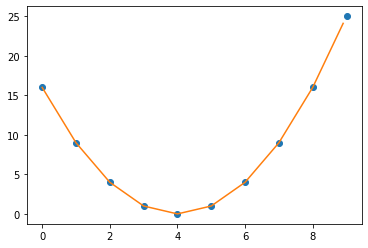

In [101]:
import matplotlib.pyplot as plt
from scipy import interpolate

# Create some control points (x,y)
x = np.arange(0, 10)
y = (x-4)**2 # let's just make up something

# create the 'INTERPOLANT' = function that does interpolation
f = interpolate.interp1d(x, y) 

# Create some new locations, where we want to guess the value of 'y' 
# using the interpolation function 'f'

xnew = np.arange(0, 9, 0.1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()




There are two types of interpolation problems: 
1. interpolation from [`gridded data`](http://uk.mathworks.com/help/matlab/math/interpolating-gridded-data.html)
2. interolation from [`scattered data`](http://uk.mathworks.com/help/matlab/math/interpolating-scattered-data.html).

Interpolation techniques designed for scattered data can of course also be used for gridded data.  However, functions specific for gridded data cannot typically be used for scattered data. This is because functions for gridded data make a priori assumptions about the regular spacing and arrangements of the control points to maximize computing efficiency.

Order in the data relates to computational efficiency because the computer doesn't have to look for the data in its memory and sort them in the sequence they are needed for the calculation, the data are already conveniently all next to one-another. In that case, the computer can very efficiently calculate differences between neighboring points, such as $x(i+1)-x(i)$, with these differences having meaning (e.g. a finite difference). This is not the case in scattered datasets where there is no obvious connection between the i$^{th}$ data point and the i$^{th}$+1 or i$^{th}$-1 sample. Extra computational steps are needed when dealing with scattered data.


<a id='gridded'></a>
## Gridded data

By definition, gridded data exist on a `grid`! **A grid is defined by an ordered sequence of coordinates**. 

If there are, say, 7 values on the x-axis and 7 values on the y-axis, a full grid will contain a set of $7\times 7=49$ coordinates. Given vectors of **x** and **y** values, Python `numpy` has a function called [`numpy.meshgrid`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) that automatically creates the arrays **X** and **Y** that contain the coordinates of all grid points given the vectors **x** and **y**. 

For example: 

In [102]:
import numpy as np
nx, ny = (7,7)
x = np.linspace(-3, 3, nx) # define a vector of x-axis coordinates
y = np.linspace(-3, 3, ny) # define a vector of y-axis coordinates
print('x =', x)
print('y =', y)

X, Y = np.meshgrid(x, y) # define a matrix/array with X and Y of coordinates

print('grid X =', X)
print('grid Y =', Y)

x = [-3. -2. -1.  0.  1.  2.  3.]
y = [-3. -2. -1.  0.  1.  2.  3.]
grid X = [[-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]
 [-3. -2. -1.  0.  1.  2.  3.]]
grid Y = [[-3. -3. -3. -3. -3. -3. -3.]
 [-2. -2. -2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1. -1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.  3.  3.]]


One can then use the arrays **X** and **Y** to directly evaluate functions over the entire grid, for example.

**Note**: When working with model output, you may see that the latitudes an longitudes may be supplied either as vectors (**x,y**) or as two arrays (**X,Y**). This generally depends on whether the data are supplied on a regular grid (fixed latitudes and longtiude steps), or not. The native model grids are rarely regular (they can be curved and the resolution typically changes regionally, so providing vectors of latitudes and longitudes simply wouldn't make any sense). 

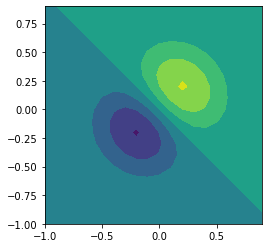

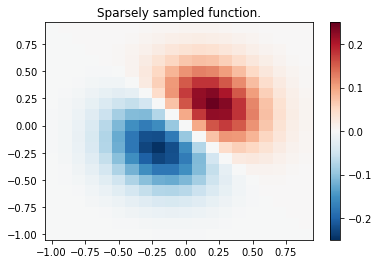

In [103]:
import matplotlib.pyplot as plt
x = np.arange(-1, 1, 0.1)
y = np.arange(-1, 1, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)
z = (xx+yy) * np.exp(-6.0*(xx*xx+yy*yy))

## here is one view, as a filled contour
h = plt.contourf(x, y, z)
plt.axis('scaled')
plt.show()

## here is another view, as a shaded colormesh, with a color bar 
plt.figure()
lims = dict(cmap='RdBu_r', vmin=-0.25, vmax=0.25)
plt.pcolormesh(x, y, z, shading='auto', **lims)
plt.colorbar()
plt.title("Sparsely sampled function.")
plt.show()

Note that Python's `numpy.meshgrid` commmand has an option called `indexing`.
This means that `meshgrid` can support both indexing conventions: 
* Giving the string `indexing=‘ij’` returns a meshgrid with matrix indexing (row/column)
* Giving the string `indexing=‘xy’` returns a meshgrid with Cartesian indexing (longitude/latitude)
 In the 2-D case with inputs of length M and N, the outputs are of shape (N, M) for ‘xy’ indexing and (M, N) for ‘ij’ indexing. This means that the x-axis is first in 'xy', but 'rows' (i.e. y-axis) are first in the matrix case. So 'ij' and 'xy' are transposes of each other. In the 3-D case with inputs of length M, N and P, outputs are of shape (N, M, P) for ‘xy’ indexing and (M, N, P) for ‘ij’ indexing. 

Some functions may need inputs in one or ther other format - beware for this and pay attention!

[`interpn`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html) performs N-D interpolation of gridded data. Here is an example: 

In [104]:
from scipy.interpolate import interpn

# let's create a function to create synthetic values of z
def value_func_3d(x, y, z):
     return 2 * x + 3 * y - z

# define a 3D grid
x = np.linspace(0, 4, 5)
y = np.linspace(0, 5, 6)
z = np.linspace(0, 6, 7)
points = (x, y, z)

# evalulate the function to get 'values' on that 3D grid
values = value_func_3d(*np.meshgrid(*points, indexing='ij'))

# Now use interpolation
point = np.array([2.21, 3.12, 1.15]) # create a 3D 'query' point
print(interpn(points, values, point)) # user interpn and see the value of z here

[12.63]


<a id='scattered'></a>
## Scattered or unstructured data

Scattered data consist of sets of points **x** and **y** that are not ordered in any particular way. 

One widely used approach to interpolate scattered data is based on the [`Delaunay triangulation`](https://docs.scipy.org/doc/scipy/reference/spatial.html#module-scipy.spatial) technique ([`scipy.spatial.Delauney`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Delaunay.html)). 

Delaunay triangulation **uses the data coordinates as vortices of triangles**. The triangles are chosen so that the circumcircles (a circle touching all 3 vertices) associated with each triangle contain no other points in its interior. Once the points defining the verticies of each triangle are defined, one can use a variety of traditional interpolation techniques to interpolate within each triangle using the 3 vertices as control points.  

By design, **interpolation cannot extrapolate** and as such it can only generate guesses for query points located inside the **convex hull** of the data. The convex hull is a set of points that defines an envelope containing all points. 

Python has a function that can isolate the convex hull called [`scipy.spatial.ConvexHull`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html). 

To visualize the convex hull surrounding a set of random point, try the following commands:

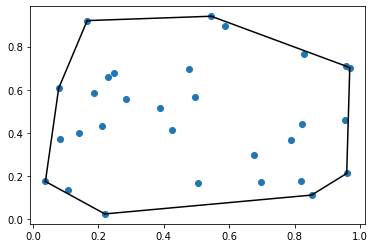

In [105]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

# create some random coordinates
rng = np.random.default_rng()
points = rng.random((30, 2))   # 30 random points in 2-D

# calcualte the convex hull around these points
hull = ConvexHull(points)

# plot the convex hull
import matplotlib.pyplot as plt
plt.plot(points[:,0], points[:,1], 'o')
for simplex in hull.simplices:
       plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

Let's now see how we could perform Delauney triangulation. 

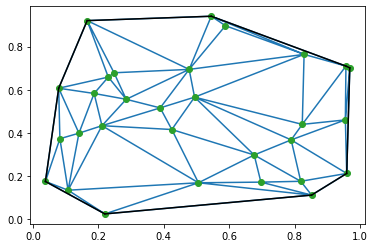

In [106]:

from scipy.spatial import Delaunay
tri = Delaunay(points)

import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')

for simplex in hull.simplices:
       plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        
plt.show()

Python has a function to do scattered interpolation (interpolate unstructured data) called [`scipy.interpolate.griddata`](https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata). This function essentially performs a Delauney triangulation of the data, and then interpolates within the triangles. There are 3 options to interpolate: nearest, linear, cubic. 


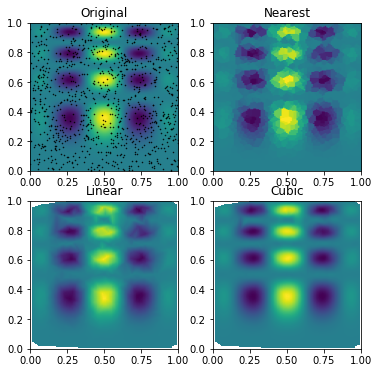

In [107]:
def func(x, y):
    #return  (x+y) * np.exp(-6.0*(x*x+y*y))
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
    
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

NPOINTS=1000
rng = np.random.default_rng()
points = rng.random((NPOINTS, 2))
values = func(points[:,0], points[:,1])

from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower') 
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

Now let's explore how the interpolation depends on the number of sample points. Decrease the number of points from 1000 to 100. Also see how the area that is interpolated over is limited by the convex hull of the data. 


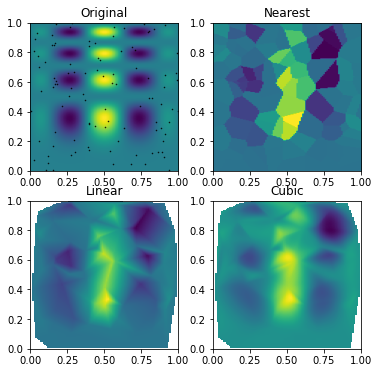

In [108]:
def func(x, y):
    #return  (x+y) * np.exp(-6.0*(x*x+y*y))
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
    
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

NPOINTS =100
rng = np.random.default_rng()
points = rng.random((NPOINTS, 2))
values = func(points[:,0], points[:,1])

from scipy.interpolate import griddata
# There are 3 different interpolation options within the Delauney triangulation
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower') 
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [109]:
import numpy as np
from scipy.interpolate import griddata

# create some random sample coordinates
z = np.random.rand(100, 100)
z.shape = (100, 100)
x, y = np.arange(-5, 5, 0.1), np.arange(-5, 5, 0.1)

xx, yy = np.meshgrid(x, y, indexing='ij')

newx, newy = np.arange(-2, 2, 0.1), np.arange(-2, 2, 0.1)

griddata((xx.ravel(), yy.ravel()), z.ravel(), (newx[None, :], newy[:, None]))

array([[0.97760966, 0.89657707, 0.61350751, ..., 0.90841192, 0.51651747,
        0.16903811],
       [0.56729825, 0.79166334, 0.47124727, ..., 0.9455018 , 0.07571998,
        0.15877667],
       [0.94276536, 0.8182261 , 0.85639294, ..., 0.19440455, 0.91462713,
        0.73118271],
       ...,
       [0.50314455, 0.12489674, 0.64628817, ..., 0.79842107, 0.83831065,
        0.4616147 ],
       [0.31449153, 0.82677281, 0.30380303, ..., 0.20757916, 0.2668406 ,
        0.2387054 ],
       [0.71129365, 0.98526912, 0.01687577, ..., 0.67739754, 0.03017977,
        0.37665575]])

<a id='fitting'></a>
# Surface fitting

The interpolation techniques described above work very well when the space is relatively well-sampled, when one does not want to extrapolate beyond the convex hull and in the absence of variability or uncertainties associated the control points. If these conditions are not met, a better approach to interpreting spatial data may be **to fit a surface across the collection of samples** rather than to force a surface to pass exactly through each control point. This process is sometimes called optimal interpolation because it involves mininizing misfit errors.

An optimally interpolated surface will tend to be smoother than the original data field. 

The contoured values at locations where samples exist won't equal to the data point at that location due to the noise associated with each measurement. The contoured estimate will tend to either over or underestimate the true value, within a tolerance controlled by the noise associated with the measurements. 

The shape of the fitted surface will depend strongly on the data available: their locations, their uncertainties, as well as subjective choices made during the analysis (i.e. definition of the so-called 'covariance matrix').

We will here look at a technique called **kriging**, pioneered by a South African mining engineer called Danie G. Krige (1919-2013) and further formalized by geologist and mathematician Georges Matheron (1930-2000), who, together with Jean Serra, is often considered to be the founder of geostatistics.


### Krigging (a.k.a objective mapping, a.k.a Gauss-Markov regression)

Kriging takes many names, depending on the field of study. In oceanography, for example, a simplified version of the technique has crept through under the name objective mapping. 

In jargon, kriging is essentially a fitting process constrained by an underlying Gauss-Markov process model, itself controlled by prior covariances. This latter statement could be translated as follows.

Just as time-series were characterized by an autocorrelation function indicating that the values at time $t$ were not necessarily independent from previous values at times $t-\tau$, points in space $(x_i,y_i)$ can also be thought of as correlated with any number of neighboring points $(x_k,y_k)$, $(x_l,y_l)$, etc. In time-series analysis and geostatistics, a Gauss-Markov regression model is a means of specifying the degree of correlation (i.e the memory) between neighboring points. The degree of influence that a point has on another point (i.e. the memory) is specified by means of a covariance matrix. We will now outline the mathematics inolved. 


#### Mathematical formulation (only the basic setup of the problem, not the solution)

The general problem is to compute an estimate $\hat{F}(\vec{x}_0,t)$ of the true field $F(\vec{x}_0,t)$ at query position $\vec{x}_0$ from a finite number of scattered observations $f(\vec{x}_n,t)$ taken at locations $\vec{x}_n$, with $n=1,2,...,N$.

If we consider a snap-shot in time, i.e. dropping the time index $t$, the generalized kriging problem can be stated as

\begin{equation}
\hat{F}(\vec{x}_0)=\overline{F(\vec{x})}+\sum\limits_{i=1}^Nb(x_i)(f(x_i)-\overline{f(x_i)})
\end{equation}

where the overbars denote the expectation value (i.e. the mean) and the $b(x_i)$ are yet unspecified weighting coefficients for each data point $x_i$, subject to $\sum\limits_{i=1}^Nb(x_i)=1$.

The generalized kriging problem equation above means that to predict the value of the field $\hat{F}(\vec{x}_0)$ at a query location $\vec{x}_0$, a good guess is to start with the mean (or some known structure) of the overall field $\overline{F(\vec{x})}$, to which we add corrections. For any given query point $\vec{x}_0$, the necessary correction is calcuated as a weighted sum of contributions from the available samples $x_i$. The big question is what values should the weight corresponding to each sample have? Answering this question is not easy - it is basically the whole point of kriging. The answer will depend on any additional constraints that one applies on these weights and on any additional properties one wishes the field $F$ or $D$ to have (stationarity of various moments, isotropy, etc.). Different assumptions/requirements results in different types of kriging: **simple kriging**, **ordinary kriging**, **universal kriging**, etc. In all cases, though, the weights $b(x_i)$ are obtained by using least-squares optimization and minimizing the error defined by the difference between the true field and the prediction.

A full mathematical description is beyond the scope here, but we will just point out that implementation of krigging in practice usually requires the user to specify a `variogram`.


#### Variograms, correlograms and semi-variograms

Krigging requires estimation of a so-called covariance matrix, which describes the relationship between observations. Defining the elements of the covariance matrix is an 'art-form'.

One may choose to use an existing form of a covariance function, also called covariogram, or just variogram. The semivariogram, often defined as $\gamma(h)$ is $1/2$ the variogram.  

Popular examples of isotropic semivariograms are:
1. Exponential semivariogram model
  \begin{equation}
    \gamma(h)=(s-n)\left(1-exp\left(\frac{-h}{ra}\right)\right)+n_{(0,\infty)}
  \end{equation}
    
2. Gaussian semivariogram model
  \begin{equation}
    \gamma(h)=(s-n)\left(1-exp\left(\frac{h^2}{a^2}\right)\right)+n_{(0,\infty)}
  \end{equation}
  
3. Spherical semivariogram model
  \begin{equation}
  \gamma(h) =
  \begin{cases}
    (s-n)\left(\frac{3}{2}\frac{h}{a}-\frac{1}{2}\left( \frac{h}{a}\right)^3 \right)+n_{(0,\infty)} & \text{for }h\le a,\\
    (s-n) & \text{for }h > a.
  \end{cases}
  \end{equation}


In the functions above, $h$ is distance. $s$ is called the `sill`, the value that $\gamma(h)$ tends to as h goes to $\infty$. $r$ is the `range`, or the distance at which the difference $\gamma(h)-s$ becomes negligible. $n$ is called the `nugget` parameter. It is an offset that applies for all $h>0$. The nugget parameter accounts for very small scale heterogenities. Imagine measuring gold concentration at point $x_0$ which happens to be in a gold nugget. A finite distance away, gold concentration falls drastically, but beyond that, the concentration may decrease progressively. The nugget parameter aims to account for this type of jumps. $a$ is a constant, which varies, often it is $1/3$.

![variogram](img/variogramexample.png)

More detailed information on variograms be found [here](https://medium.com/@nikhil.munna001/kriging-implementation-in-python-with-source-code-541b9b5c35f)

**Anisotrophic variogram**, that not only depend on $h$, but also on the direction of the vector $h$ models, also exist. Anisotropic variograms are routinely used in oceanography, where meridional motions away from boundaries are strongly restricted by the Earth rotation. For this reason, maps made for oceanic tracers tend to use a long longitudinal range and a short latitudinal range.


If we have a dense dataset, one may try to estimate the variogram empirically. To achieve this, one first subtract the mean (or a trend) from the data. We then **bin all possible pairs of data by their distance of separation** in intervals of say $k\Delta h$, with $k=1,2,...,K$. At this point, one can either compute the **spatial covariance**

\begin{equation}
C(k \Delta h)=\frac{1}{m}\sum\limits_{i=1}^md(x_i+k\Delta h)d(x_i)
\end{equation}

from which we can compute the **correlogram**, which is simply the spatial covariance normalized by the data variance (at $k=0$) so as to limit its range to $\pm 1$,

\label{eq:corelogram}
\begin{equation}
\rho(k \Delta  h)=\frac{C(k \Delta h)}{C(0)}=\frac{\frac{1}{m}\sum\limits_{i=1}^md(x_i+k \Delta  h)d(x_i)}{\frac{1}{m}\sum\limits_{i=1}^m(d(x_i)^2)}
\end{equation}

or look at the mean squared difference and form the **semivariogram**

\begin{equation}
\gamma(k \Delta  h)=\frac{1}{2m}\sum\limits_{i=1}^m\left(d(x_i+k\Delta h)d(x_i)\right)^2.
\end{equation}

The functional forms $C(h)$, $\rho(h)$ or $\gamma(h)$ of these binned, discrete estimates is obtained simply by plotting $C(k\Delta h)$, $\rho(k\Delta  h)$ or $\gamma(k\Delta  h)$ as a function of $k\Delta h$ and by fitting a polynomial throught the results that ensures strictly positive values of $C(h)$, $\rho(h)$ or $\gamma(h)$ for any $h$.

Note that the corelogram in geostatistics is very similar to the autocorrelation function used in time-series analysis. Indeed, as the lag-distance increases, both $\rho(h)$ and $C(h)$ decrease, while $\gamma(h)$ increases.

---

<a id='plot'></a>
# Plotting and manipulating spatial data

## Geopandas, Cartopy, scipy.spatial and others...

[Geopandas](https://geopandas.org/en/stable/index.html) is an open-source python library that makes working with geospatial data easier. It aims to deliver the benefits of `pandas` to geospatial data. 

[Cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html) is a python package designed for geospatial data processing and mapping. It makes working with various geographical projections easier. 

[scipy.spatial](https://docs.scipy.org/doc/scipy/reference/spatial.html) is a component of the popular [`scipy`](https://docs.scipy.org/doc/scipy/getting_started.html) library. It contains a few handy algorithms to handle and manipulate spatial data, such as performing nearest neighbor queries or applying Delauney triangulation, which is useful for spatial interpolation.   

One can easily install [geopandas](https://geopandas.org/en/stable/getting_started/install.html), [cartopy](https://scitools.org.uk/cartopy/docs/latest/installing.html) and [scipy](https://docs.scipy.org/doc/scipy/getting_started.html), for example with: 
> conda install -c conda-forge geopandas
> conda install -c conda-forge cartopy\
> condal install scipy

Note, these packages build on other popular libraries and python packages designed to help with geospatial data analysis, for example [GDAL](https://gdal.org/), [PROJ](https://proj.org/) and [pyproj](https://github.com/pyproj4/pyproj/), [GEOS](https://trac.osgeo.org/geos/) and [PyGEOS](https://github.com/pygeos/pygeos/), [Shapely](https://github.com/Toblerity/Shapely), [pyshp](https://pypi.python.org/pypi/pyshp), [fiona](https://fiona.readthedocs.io/), [rtree](https://github.com/Toblerity/rtree). Beware, there are dependencies between these packages that have to be resolved and that could cause issues when setting up environments. 

Of these, two libraries are critical as they are the foundation of most other tools used in geostatistics:

* **PROJ** provides methods for coordinate representation, conversion (projection) and transformation
* **GDAL** allows reading and writing of spatial raster and vector data in a standardised form, and provides a high-level interface to PROJ for these data structures, including the representation of coordinate reference systems (CRS)


Geostatistics can be confusing in part because of the plethora of packages, many of which claiming to do similar things, but usually in different ways or using different formats, or with different levels of success, memory implication or compute speed.  

We note also that Geographical Information Systems softwares, such as free [QGIS](https://www.qgis.org/en/site/) (or [ArcGIS](https://www.arcgis.com/index.html), which is not free) allow users to define built-in python extensions as well. There is a lot of synergies between python and GIS softwares. 



<a id='crs'></a>
### The problem of Coordinate Reference Systems (CRS)

The coordinate Reference Systems (CRS) is a critical piece of information as it provide a way to geo-reference collections of coordinates, it relates them to a specific place on Earth (or on other planets/bodies). Without a CRS, coordinates are just collections of points in arbitrary space. The CRS is needed to compare geospatial data with one another and, generally, to support data interpretation.

Definition of a CRS generally consists of two pieces of information:
1. one coordinate system
2. one datum
   
For coordinate systems that are derived from some standard one, then one must also, of course, specify the conversion needed. 

The `datum` roots the coordinate system to an arbitrary object. In our case, we are mostly dealing with the Earth, but this could be any object, i.e. an asteroid, a building, a car or a potato, etc. The objective is to ensure that whatever coordinate system is then chosen can be used to practially, and repeatedly,  describe positions on the object. If one defines the datum of the object, then in theory, the object can also be moving and we will still be able to pin-point a feature on the object irrespective of that motion, i.e. relative to the object itself, given that object's CRS. 

The datum itself can move through time (if that is the case, that temporal shift has to be defined too). For example, when thinking of the Earth through its geological evolution, plate tectonic led to crustal deformation, such that the 'datum surface' of the Earth surface actually changed over millions of years. This is not an issue for most modern applications and in most cases, we can safely assume the datum to be fixed, but temporal datum shifts could affect the work of someone working on very long time scales, or very small space scales, where changes are possible.  

**A bit of jargon, as defined in the [ISO19111:2019](http://docs.opengeospatial.org/as/18-005r4/18-005r4.html) standard for referencing by coordinates**: There are two subtypes of coordinate reference systems. The `geodetic` system is a 2 or 3D coordinate system. The `geodetic-geographic` system is what we use to describe a location on Earth (i.e. lat/lon). A second type of CRS are `engineering` systems. Engineering CRS can be and are used on Earth too, when dealing with regional/small scales, for example when we can approximate the Earth to be relatively flat. This is typically used in civil engineering applications. Engineering systems are basically systems that are not the geodetic system. Engineering CRS can be used to describe location on a moving object, or the relative position on an image, etc. 

Note, we can georeference an engineering CRS to the geodetic CRS by applying a coordinate transformation. `Transformations` are coordinate operations in which the two coordinate reference systems use different datums. `Conversions` relate to coordinate operations in which two coordinate reference systems use the same datum. 

When dealing with data on Earth, we often have to use map `projections`, which are a type of `conversions`. This leads to the concept of `projected CRS`. Projected CRS are derived from the base geodetic CRS. They are what is called `derived CRS`. 

`Compound CRS` are mixtures of geodetic and engineering CRS. These are used a lot in practice. For example, a CRS with latitude and longitude, but with depth (or altitude) in pressure. In this case, pressure (or altitude/depth) is locally defined: i.e. the vertical axis varies with location.  

On Earth, one of the most common CRS is the `WGS84` latitude-longitude projection, which is also known as code `EPSG:4326`. The origin of the coordinate system for `WGS84` is meant to be the Earth's center of mass (which is believed [known with an accuracy of better than 2~cm!](https://en.wikipedia.org/wiki/World_Geodetic_System)). The reference meridian of zero longitude is the [IERS Reference Meridian](https://en.wikipedia.org/wiki/IERS_Reference_Meridian), which is located 5.3 arc seconds, or 102 metres (335 ft) east of the Greenwich meridian at the latitude of the Royal Observatory in Greenwich, UK. The `WGS84` datum surface is defined by an oblate spheroid, with equatorial radius a = 6378137m at the equator and a flattening f = 1/298.257223563. Note that, although it is called `WGS84`, referencing its origin in 1984, the geoid component of WGS84 is continuously updated, with a latest iteration in 2020, providing a geoid accuracy better than 10cm. 

To add confusion, the same CRS can be referred to in many ways! CRS can be described in so-called `PROJ strings` format, in `Well-Known Text (WKT)` (now also evolved into [WKT2](http://docs.opengeospatial.org/is/12-063r5/12-063r5.html)), or in `Spatial Reference IDs (SRID)`. WKT (e.g. 'WGS84') or SRID (e.g. 'EPSG:4326') are generally preferred.  The [European Petroleum Survey Group (EPSG) geodetic parameter dataset](https://epsg.org/home.html) (with things like code 'EPSG:4326'), is a collection of definitions of coordinate reference systems and coordinate transformations. The [EPSG dataset](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) is now maintain by the Geodesy Subcommittee of the [International Association of Oil and Gas Producers (IOGP) Geomatics Committee](https://www.iogp.org/geomatics/), but the EPSG name was kept to avoid further confusion. Alternatively, [spatialreference.org](https://spatialreference.org) also provides a list of available codes and CRS used. 

[A few common CRS](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) are:
* EPSG:4326, which is WGS84, the latitude/longitude system based on the Earth's center of mass
* EPSG:3857, which corresponds to a mercator projection, used by Google Maps and OpenStreetMap
* EPSG:7789, which is known as ITRF2014, the International Terrestrial Reference Frame, and is a system (for Earth) that is inedpendent of plate tectonics (which changes the location of the Earth's center of mass)

Since users can always define their own CRS/codes, based on one's application and needs, the published list of CRS is not exhaustive. Obviously, if one wants our custom  (non-standard) CRS to be used and understood by others, this information has to be communicated and archived to ensure legacy of our analysis, so one should always either work from existing CRS, or publish them (on [EPSG](https://epsg.org/search/by-name) for example). 

# PROJ

* [PROJ](https://proj.org/index.html) is a generic coordinate transformation software that transforms geospatial coordinates from one coordinate reference system (CRS) to another. PROJ can do `transformations`, `conversions` and `projections`. PROJ provides a series of [command line utilites](https://proj.org/apps/index.html#apps), to be used in a terminal window, shell script, etc, but APIs are available too. 

* PROJ is a [foundational piece of the open source geospatial ecosystem](https://jorisvandenbossche.github.io/blog/2020/02/11/geopandas-pyproj-crs/). PROJ is used by many geospatial projects, including Cartopy and Geopandas, but also GDAL, QGIS, etc. [pyproj](https://pyproj4.github.io/pyproj/stable/) provides a more user-friendly python interface to PROJ. Although the various python packages used for geospatial analysis interface with PROJ in their own way (i.e can use a different interface), at the core of it, the calculations are generally all similar as performed by PROJ. 

By construction, PROJ expects axis ordering as defined by the autority in charge of a defined CRS, as per the [ISO19111:2019](http://docs.opengeospatial.org/as/18-005r4/18-005r4.html) standard. PROJ normally uses a (longitude, latitude) tuple. However, depending on the package one uses that interfaces with PROJ, the order may differ, so one may have to provide latitutde/longitude instead (even if in the background, this will be flipped for PROJ). A note of caution is therefore needed to always check the order in which axes are expected. 

The command line utility [`projinfo`](https://proj.org/apps/projinfo.html) (from PROJ) can be used to see how the CRS expects input. For instance, the command
> projinfo EPSG:4326

returns all the details about that coordinate reference system. We can see below how `PROJ strings`, `WKT` and `SRID` are defined. We can also see information about units, axes, and the definition of the ellipsoid used.  

**Little trick**: Sometimes, it can be useful to execute system commands (i.e. shell commands) from within python. For example, one could use this technique to use the NCO operators to manipuate NetCDF files quickly, within the workflow of a python function or script, benefiting from python's user friendliness and of NCO's speed and efficiency. As explained [here](https://www.askpython.com/python-modules/python-system-command), there are many ways to interact with the system: `os` and `subprocess` can both be used to achieve this. Here are a couple of examples showing how to execute the 'projinfo' command line operation from with python: 

In [110]:
import os
 
command = "projinfo EPSG:4326" #command to be executed
 
res = os.system(command)
#the method returns the exit status

print("Exit code: ", res) # print the exit code

PROJ.4 string:
+proj=longlat +datum=WGS84 +no_defs +type=crs

WKT2:2019 string:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["Horizontal component of 3D system."],
    

In [111]:
import subprocess
 
command = "projinfo EPSG:4326" #command to be executed
 
res = subprocess.call(command, shell = True)
#the method returns the exit code

## Note that `subprocess.check_output()` can also be used if we want to manipulate the way 
## we want to get the output from the system call (experiment with this).
 
print("Exit code: ", res) # print the exit code

PROJ.4 string:
+proj=longlat +datum=WGS84 +no_defs +type=crs

WKT2:2019 string:
GEOGCRS["WGS 84",
    ENSEMBLE["World Geodetic System 1984 ensemble",
        MEMBER["World Geodetic System 1984 (Transit)"],
        MEMBER["World Geodetic System 1984 (G730)"],
        MEMBER["World Geodetic System 1984 (G873)"],
        MEMBER["World Geodetic System 1984 (G1150)"],
        MEMBER["World Geodetic System 1984 (G1674)"],
        MEMBER["World Geodetic System 1984 (G1762)"],
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]],
        ENSEMBLEACCURACY[2.0]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    USAGE[
        SCOPE["Horizontal component of 3D system."],
    

**Longitude wrapping in PROJ**: PROJ wraps around longitudes by default into the -180:+180 range. The `+lon_wrap` option can be used, however, to specify a different central longitude (different than 0), so `+lon_wrap=180` would yield longitudes between 0:360. The `+over` switch can be used to exceed these limits, which can be convenient when showing certain features near the edges/limits of the maps. 

# GDAL: Geospatial Data Abstraction Library

[GDAL](https://gdal.org/index.html)is a C++ translator library for over 200 raster and vector geospatial data formats. It is maintained by the [Open Source Geospatial Foundation](https://www.osgeo.org).  

GDAL functions are used for reading and writing raster and vector geospatial formats, perform data format translation and for geospatial data processing, such as subsetting, image warping, reprojection, mosaicing, tiling, DEM processing. 

Together, PROJ and GDAL form the foundation of most geospatial softwares.
* PROJ provides methods for coordinate representation, conversion (projection) and transformation
* GDAL allows reading and writing of spatial raster and vector data in a standardised form, and provides a high-level interface to PROJ for these data structures, including the representation of coordinate reference systems (CRS)

[APIs](https://gdal.org/api/index.html) for various languagues exist, including a [python API](https://gdal.org/api/index.html#python-api). The python version (as the `osgeo` package) can be installed from pip or conda (as `conda install -c conda-forge gdal`). Strictly speaking, when installing the python 'gdal' distribution, it is composed of two libraries: 
1. GDAL itself, used for manipulating geospatial **raster** data 
2. and OGR, which is used for manipulating geospatial **vector** data

Vector data is made up of points, lines, and polygons. On the other hand, raster data are 2D, 3D, ND dimensional arrays of data values, such as pixels in a photograph, or data values in a gridded data file. We are more used to think in terms of raster than in terms of vectors because rasters are basically matrices of data. 
 
(You will learn more on raster and vector data with Philippa Mason.)

There are five major modules (grouped under `osgeo`): 

In [112]:
from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst

Other packages, such as `fiona`, which is used to read and write vector data is build on top of `OGR`, which is part of the GDAL distribution. `rasterio` is another packges used to manipulate raster data that is build on GDAL. `Shapely` is another pacakge that makes manipulating geometric elements easier. 

### Learning resources to use GDAL

Unfortunately, there is no easy to read and helpful user guide, so the learning curve is steep, but various freely available [tutorials](https://gdal.org/tutorials/), [sample scripts](https://github.com/OSGeo/gdal/tree/master/swig/python/gdal-utils/osgeo_utils/samples) and [examples](https://gdal.org/api/python.html) are availble. One can list in particular the Python GDAL/OGR [cookbook](http://pcjericks.github.io/py-gdalogr-cookbook/index.html). The [GDAL mailing list](https://lists.osgeo.org/listinfo/gdal-dev) is also a place to ask for help and look for GDAL specific information. 

The book (not free, but not expensive) ['Geoprocessing with Python'](https://www.manning.com/books/geoprocessing-with-python) by Chris Garrard is also an excellent resource. Example code from the book can also be downloaded from the [publisher's webiste, Manning](https://www.manning.com/books/geoprocessing-with-python) or from the [author's github](https://github.com/cgarrard/osgeopy-code), with the files used for exercises and examples in the book found [here](https://app.box.com/s/1cwdnolsmtf0s04o0hshbv4vxiuqcmi9). 


<a id='geopandas'></a>
# Geopandas

Geopandas is aimed to be like pandas, but to work with geodata and shapefiles. Geopandas dataframes also behave a lot like pandas dataframes. 

There are many programmes out there to make maps, and some, like QGIS and ArcGIS are obviously excellent, but when automation is required, for reproducibility for example, it is practical to be able to make maps using a prorgramming language like python. 

An excellent example showing how to use geopandas to create a chloropleth map was published on [medium.com](https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d) by B.D. Cooley. This tutorial produces the following result. 

![Geopandasexample](img/geopanda_medium.png)

This example also uses data from the [London Datastore](https://data.london.gov.uk), which provides access to a lot of nice data for this. Have a look at the [datasets](https://data.london.gov.uk/dataset) available. 

To run the published example, one could download the [`statistical-gis-boundaries-london.zip  (27.34 MB)`](https://data.london.gov.uk/download/statistical-gis-boundary-files-london/9ba8c833-6370-4b11-abdc-314aa020d5e0/statistical-gis-boundaries-london.zip) or the [`London-wards-2018.zip  (5.71 MB)`](https://data.london.gov.uk/download/statistical-gis-boundary-files-london/08d31995-dd27-423c-a987-57fe8e952990/London-wards-2018.zip) files from the London Datastore. These data will provide the `shapefiles` necessary to delineate the different London boroughs, basically a set of lines that help establish the 'map' aspect. 

Next, one needs data for each of these borough. One could use the [Borough profile dataset](https://data.london.gov.uk/dataset/london-borough-profiles) from the DataStore. Read the information about this dataset. Get the Excel [XLS](https://data.london.gov.uk/dataset/london-borough-profiles/resource/80647ce7-14f3-4e31-b1cd-d5f7ea3553be/download) version. To see the full set of data for all 33 local authorities in London, click the 'Data' worksheet.

We also note the following statement on the download page `On maps created using these boundaries the copyright must be stated. This is: "Contains National Statistics data © Crown copyright and database right [2015]" and "Contains Ordnance Survey data © Crown copyright and database right [2015]"`. Should one be developing a map for other purposes than simply learning a skill, we would of course have to add that information to our product. 


<a id='cartopy'></a>
# Cartopy

![cartopy](img/cartopy.png)

Now that we understand a bit the foundation (i.e. PROJ) behind geospatial software, let's see how to use `cartopy` by means of a few examples. Naturally, [the full documentation](https://scitools.org.uk/cartopy/docs/latest/index.html) should be consulted for more details and information. 

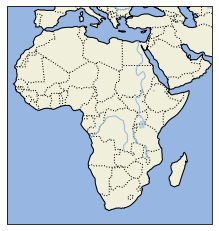

In [113]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


def main():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([-20, 60, -40, 45], crs=ccrs.PlateCarree())

    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.RIVERS)

    plt.savefig("output/cartopytest.png",dpi=300)
    plt.show()


if __name__ == '__main__':
    main()

<a id='example'></a>
# A nicer example!
## Making a map for research purposes (by Arianna Olivelli)

In [114]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import netCDF4 as netcdf
import xarray as xr # we haven't yet discussed 'xarray' (likely in the BIG DATA module)
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [115]:
#set directory and import files (these files are in the /data directory)
directory = 'data/AVISO/'

uaviso = xr.open_dataset(directory + 'uaviso.nc')
vaviso= xr.open_dataset(directory + 'vaviso.nc')

In [116]:
#slice dataset - include data from the Indian Ocean only (you can play with this as you wish)

uaviso = uaviso.sel(longitude = slice(16, 120))
uaviso = uaviso.sel(latitude = slice(-75, 0))
uaviso

vaviso = vaviso.sel(longitude = slice(16, 120))
vaviso = vaviso.sel(latitude = slice(-75, 0))
vaviso

<xarray.Dataset>
Dimensions:    (latitude: 300, longitude: 416)
Coordinates:
  * latitude   (latitude) float64 -74.88 -74.62 -74.38 ... -0.625 -0.375 -0.125
  * longitude  (longitude) float64 16.12 16.38 16.62 16.88 ... 119.4 119.6 119.9
Data variables:
    altitude   float64 ...
    time       datetime64[ns] ...
    v_current  (latitude, longitude) float32 ...
Attributes: (12/51)
    acknowledgement:               NOAA NESDIS COASTWATCH, NOAA SWFSC ERD
    cdm_data_type:                 Grid
    composite:                     true
    contributor_name:              Aviso
    contributor_role:              Source of level 2 data.
    Conventions:                   COARDS, CF-1.4, Unidata Dataset Discovery ...
    ...                            ...
    summary:                       Aviso Zonal Geostrophic Current is inferre...
    time_coverage_end:             2009-06-16T00:00:00Z
    time_coverage_start:           2009-06-16T00:00:00Z
    title:                         Currents, Geostrophic, Aviso, Global (Mont...
    Westernmost_Easting:           0.125
    nco_openmp_thread_number:      1

In [117]:
#create individual arrays for each variable. 
#Latitude and longitude are corresponding in uaviso and vaviso, so we can arbitrarily chose one to set our lat and lon variables

lat=uaviso['latitude']
lon=uaviso['longitude']
u_current=uaviso['u_current']
v_current=vaviso['v_current']

In [118]:
#calculate total velocity from u and v components

vel_tot = xr.ufuncs.sqrt(xr.ufuncs.square(u_current) + xr.ufuncs.square(v_current))
vel_tot.attrs['units'] = 'm/s'
lat.attrs['units'] = '°N'
lon.attrs['units'] = '°E'
print(vel_tot)

<xarray.DataArray (latitude: 300, longitude: 416)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ..., 0.4829994 , 0.4343015 ,
               nan],
       [       nan,        nan,        nan, ..., 0.36143553, 0.27843666,
               nan],
       [       nan,        nan,        nan, ..., 0.12043727, 0.1073482 ,
               nan]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 -74.88 -74.62 -74.38 ... -0.625 -0.375 -0.125
  * longitude  (longitude) float64 16.12 16.38 16.62 16.88 ... 119.4 119.6 119.9
Attributes:
    units:    m/s


Text(0.5, 1.0, 'Sea surface velocity')

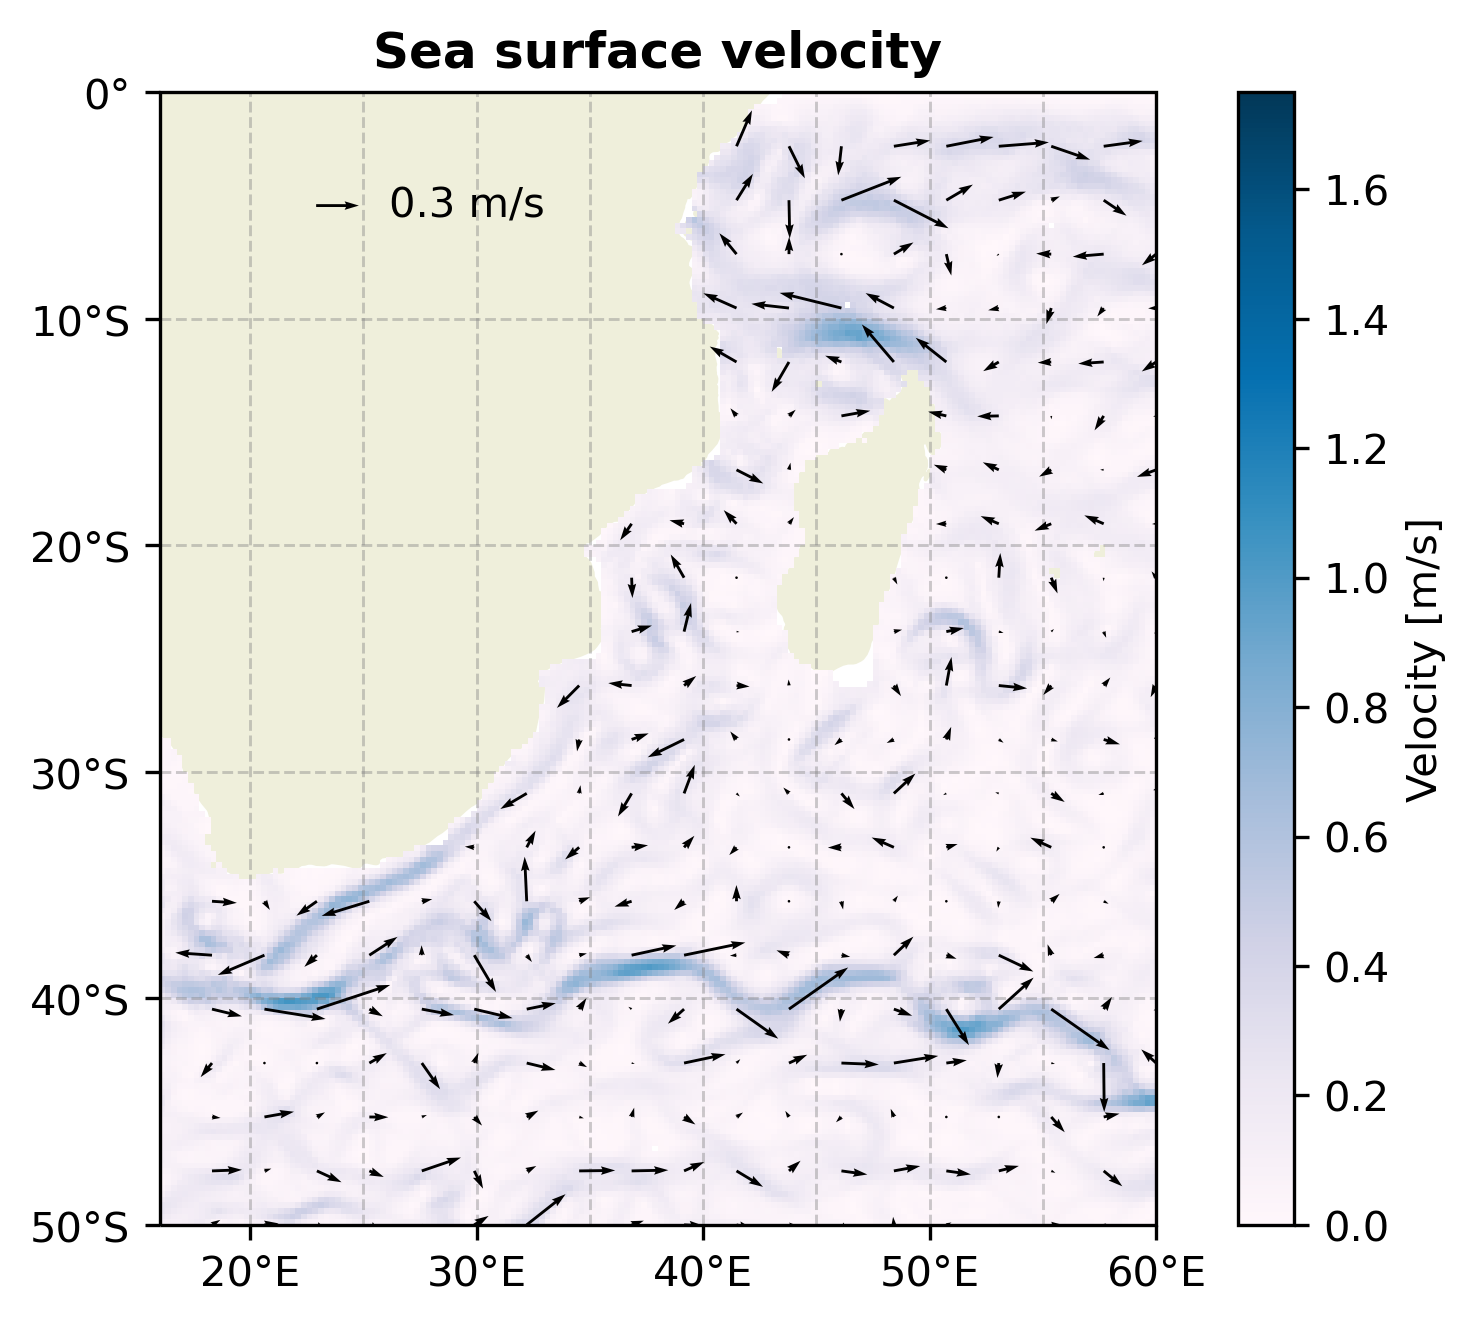

In [119]:
#set grid for plotting and quiver
regrid_shape = 20
X,Y = np.meshgrid(lon,lat)
fig = plt.figure(figsize=[7,5], dpi = 300)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cartopy.feature.LAND, zorder=1)
ax.set_extent([16, 60, -50, 0], ccrs.PlateCarree()) #this sets the dimensions of your map (west-east-norht-south extent)
ax.set_xticks([20, 30, 40, 50, 60], crs=ccrs.PlateCarree())
ax.set_yticks([-50, -40, -30, -20, -10, 0], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter() #zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=0.7, color='gray', alpha=0.4, linestyle='--')
gl.xlocator = mticker.FixedLocator([20, 25, 30, 35, 40, 45, 50, 55])

#plot total velocity
p = ax.pcolormesh(lon, lat, vel_tot, vmin = 0, vmax = 1.75, shading='auto',cmap = 'PuBu', transform = ccrs.PlateCarree(), zorder=2)

#add quiver
q = ax.quiver(X,Y, u_current.values, v_current.values,
              transform = ccrs.PlateCarree(), scale = 7, regrid_shape=regrid_shape, zorder =4)
ax.quiverkey(q, X=0.2, Y=0.9, U=0.3,
             label='0.3 m/s', labelpos='E')

#set colorbar and title
plt.colorbar(p, label="Velocity [m/s]")  
plt.title('Sea surface velocity', fontsize = 12, fontweight = 'bold')